<a href="https://colab.research.google.com/github/Sompote/RIC_transformer/blob/main/sequence2sequence_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade keras-nlp #install nlp for keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.5/573.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 16.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.1.1 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.4.0 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.


In [ ]:
!pip install -q keras-core #option change system

In [ ]:
import os #option change system

os.environ["KERAS_BACKEND"] = "jax"

# Note that keras_core should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras_core as keras

Using JAX backend.


In [3]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/RIC15aug.xlsx')
data=np.array(df)
X=data[:,1:29]
Y=data[:,34:62]
x_feature=data[:,29:32]




In [4]:
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
X_feature=x_feature
X_train=X

x_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
x_feature=sc_f.fit_transform(X_feature)



In [5]:
#preparing input matrix
#first dim is time step, 2-4 is feature
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+1))
X_train_CNN[:,:,0]=x_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=x_feature[i,0]
  X_train_CNN[i,:,2]=x_feature[i,1]
  X_train_CNN[i,:,3]=x_feature[i,2]


In [ ]:
X_train_CNN.shape

(26, 28, 4)

In [ ]:
x_feature.shape

(34, 3)

In [6]:
#preparing data for training each time step for each Y data using concept seq2seq
def encoder_f(x_f,time_step): #feature encoder same feature in each sample
  shape=x_f.shape
  x=x_f
  step=time_step
  x_sum_t=x[0:1,:]
  for time in range(1,time_step):
    x_sum=x[0:1,:]
    x_sum_t=np.append(x_sum_t,x_sum,axis=0)
  sum_X=x_sum_t

  for sample in range(1,shape[0]):
    x_sum_ts=x[sample:sample+1,:]

    for time in range(1,time_step):
        x_sum=x[sample:sample+1,:]
        #x_sum=np.reshape(x_sum,(1,x_sum.shape[0],x_sum.shape[1]))


        x_sum_ts=np.append(x_sum_ts,x_sum,axis=0)

    sum_X=np.append(sum_X,x_sum_ts,axis=0)
  return sum_X

#prepare x in encoder #enter CNN and use similar encode for  smaple in diffrent time step
def encoder_x(x_cnn):
  shape=x_cnn.shape
  x=x_cnn

  x_sum_t=x[0:1,:,:]
  for time in range(1,shape[1]):
    x_sum=x[0:1,:,:]
    x_sum=np.reshape(x_sum,(1,x_sum.shape[1],x_sum.shape[2]))
    x_sum_t=np.append(x_sum_t,x_sum,axis=0)

  sum_X=x_sum_t

  for sample in range(1,shape[0]):
    x_sum_ts=x[sample:sample+1,:,:]

    for time in range(1,shape[1]):
        x_sum=x[sample,:,:]
        x_sum=np.reshape(x_sum,(1,x_sum.shape[0],x_sum.shape[1]))
        x_sum_ts=np.append(x_sum_ts,x_sum,axis=0)

    sum_X=np.append(sum_X,x_sum_ts,axis=0)
  return sum_X

def padding(x_pad,shift=1): #padding time shift right -shift right =1
  xt=x_pad
  if (shift>0):
    ap=np.zeros((xt.shape[0],shift))
    xt=np.concatenate((ap,xt), axis=1)
  xt_1 = xt[0,0:1]
  xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
  x_sum=xt_p1
  for i in range(1,x_train.shape[1]):
    xt_t = xt[0,0:i+1]
    xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

    x_sum=np.vstack((x_sum, xt_pt))
  return x_sum

#padding time shift right -shift right =1 prepare the squence for decoder usinhe previous time step
def padding_full(x_pad,shift=1):
  xt=x_pad
  if (shift>0):
    ap=np.zeros((xt.shape[0],shift))
    xt=np.concatenate((ap,xt), axis=1)

  xt_1 = xt[0,0:1]
  xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
  x_sum=xt_p1
  for i in range(1,x_train.shape[1]):
    xt_t = xt[0,0:i+1]
    xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

    x_sum=np.vstack((x_sum, xt_pt))
  x_sum_train=x_sum

  for num_s in range(1,xt.shape[0]):
    xt_1 = xt[num_s,0:1]
    xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
    x_sum=xt_p1
    for i in range(1,x_train.shape[1]):
      xt_t = xt[0,0:i+1]
      xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

      x_sum=np.vstack((x_sum, xt_pt))
    x_sum_train =np.vstack((x_sum_train, x_sum))

  return x_sum_train

def out_put(y_train): #prepare y_value each step
  y_t=y_train

  y_sum=y_t[0,0]

  for time in range(1,y_t.shape[1]):
    y_sum=np.vstack((y_sum,y_t[0,time]))
  ysum_t=y_sum

  for nums in range(1,y_t.shape[0]):
    y_sum=y_t[nums,0]
    for time in range(1,y_t.shape[1]):
      y_sum=np.vstack((y_sum,y_t[0,time]))

    ysum_t=np.vstack((ysum_t,y_sum))
  return ysum_t




x_f=encoder_f(x_feature,28)
x_train_encoder=encoder_x(X_train_CNN)
y_decode=padding_full(x_pad=y_train, shift=1)
y_decode = np.delete (y_decode, -1, axis=1)
y_train=out_put(y_train)



In [7]:
#split data
X_train, X_test, X_feature_train, X_feature_test, Y_train, Y_test, y_d_train,y_d_test = train_test_split(x_train_encoder, x_f, y_train, y_decode,random_state=1,test_size=0.2)




In [9]:
#Model generation part
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import Adam
import keras_nlp
#from attention import Attention




def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0.2, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  input = keras_nlp.layers.PositionEmbedding(sequence_length=cnn_input_shape[0])(cnn_input)

  layer=transformer_encoder(input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.2, attention_axes=None)
  cnn_output = Flatten()(layer)
  cnn_output = Dense(50, activation='linear')(cnn_output)

  cnn_model = Model(inputs=cnn_input, outputs=cnn_output,name='CNN_model')
  return cnn_model

def LSTM_model_attention(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  layer=transformer_encoder(dense_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.2,squences=True)(layer)

  head_size=64
  num_heads=10
  ff_dim=2
  num_trans_blocks=12
  dropout=0.1
  attention_axes=1
  x = layers.LayerNormalization(epsilon=1e-6)(dense_output)
  x = layers.LayerNormalization(epsilon=1e-6)( x)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(0.1)(x)
  res = x+dense_output
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(res)

  dense_output = Dense(200, activation='sigmoid')(layer)
  dense_output = Dense(50, activation='linear')(layer)

def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  layer=transformer_encoder(dense_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.2, attention_axes=None)

  dense_output = LSTM(300,return_sequences=True)(layer)

  layer = Flatten()(dense_output)

  dense_output = Dense(200, activation='sigmoid')(layer)
  dense_output = Dense(50, activation='linear')(layer)
  #dense_output=  LayerNormalization(epsilon=1e-6)(dense_output)

  dense_model = Model(inputs=dense_input, outputs=dense_output,name='LSTM_model')
  return dense_model

def encoding_model(LSTM_model,cnn_model,latent_dim):
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  layer=Dense(200, activation='sigmoid')(combined_input)
  combined_output = Dense(latent_dim, activation='linear')(layer)
  combined_model = Model(inputs=[LSTM_model.input,cnn_model.input], outputs=combined_output,name='encoding_model')
  return combined_model

def decoding_model1(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  dense_output = Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  dense_output = Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dense(100, activation='tanh')(layer)
  layer=Dense(time_step, activation='tanh')(layer)
  layer=Reshape((time_step,1))(layer)
  LSTM_out =  LSTM(1,return_sequences=True)(layer)
  output=LSTM_out[:,:,0]


  #dense_output = Dense(time_step, activation='linear')(layer)

  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def decoding_model_transformer(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent') #from decoder

  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  Dense(latent_dim, activation='sigmoid')(layerf_int)

  input_lag=Input(shape=(time_step,1), name='lag_input')
  input = keras_nlp.layers.PositionEmbedding(sequence_length=time_step)(input_lag)
  x = layers.LayerNormalization(epsilon=1e-6)(input)

  layer=transformer_encoder(x, head_size=24, num_heads=10, ff_dim=2,dropout=0, attention_axes=None)
  cnn_output = Flatten()(layer)
  layer = Dense(50, activation='linear')(cnn_output)

  #layer = LSTM(20)(input_lag)
  layer_LSTM=  Dense(latent_dim, activation='sigmoid')(layer)

  combined_input = concatenate([inputs_l, layerfeature,layer_LSTM],name='combind_feature')
  layer=Dropout(0.2)(combined_input)
  layer=Dense(30, activation='sigmoid')(layer)
  layer=Dense(5, activation='sigmoid')(layer)

  dense_output = Dense(1, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l,inputs_f,input_lag], outputs=output,name='decoding_model')
  return model

def decoding_model(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent') #from decoder

  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  Dense(latent_dim, activation='sigmoid')(layerf_int)

  input_lag=Input(shape=(time_step,1), name='lag_input')

  layer = LSTM(200,return_sequences=True)(input_lag)
  layer = Flatten()(layer)
  layer= Dense(40, activation='sigmoid')(layer)
  layer_LSTM=  Dense(latent_dim, activation='sigmoid')(layer)



  combined_input = concatenate([inputs_l, layerfeature,layer_LSTM],name='combind_feature')
  layer=Dropout(0.2)(combined_input)
  layer=Dense(30, activation='sigmoid')(layer)
  layer=Dense(5, activation='sigmoid')(layer)

  dense_output = Dense(1, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l,inputs_f,input_lag], outputs=output,name='decoding_model')
  return model

def transformer(encoding_model,decoding_model,feature_dim):
  inputs_f = Input(shape=feature_dim, name='feature')
  input_lag=Input(shape=(None,1), name='lag_input')

  inputs_l=encoding_model.output
  print(inputs_l)
  outputs = decoding_model([inputs_l,inputs_f,input_lag])
  print(outputs)
  model = Model(inputs=[inputs_f,encoding_model.input,input_lag], outputs=outputs,name='Transformer')
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])


feature_dim=X_feature.shape[1]
latent_dim=16
time_step=X_train.shape[1]
model_cnn=CNN_model(cnn_input_shape)
model_lstm= LSTM_model(LSTM_input_shape)

#model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_encoding=encoding_model(model_lstm,model_cnn,latent_dim)
model_decoding=decoding_model(latent_dim,feature_dim,time_step)
model_decoding_transformer=decoding_model_transformer(latent_dim,feature_dim,time_step)

model_transform=transformer(model_encoding,model_decoding,feature_dim)
#adam.learning_rate=0.001
model_transform.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model_transform.summary()


#from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', save_best_only=True)



history=model_transform.fit([X_feature_train,X_train, X_train,y_d_train],
                            Y_train, epochs=2000, batch_size=30,validation_data=([X_feature_test,X_test,X_test,y_d_test], Y_test))

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense_23/BiasAdd:0', description="created by layer 'dense_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='decoding_model/dense_30/BiasAdd:0', description="created by layer 'decoding_model'")
Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LSTM_input (InputLayer)     [(None, 28, 4)]              0         []                            
                                                                                                  
 CNN_input (InputLayer)      [(None, 28, 4)]              0         []                            
                                                                                                  
 layer_normalization_9 (Lay  (None, 28, 4)                8    

In [10]:
model_transform.save('transformer_large_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def mape(y_true, y_pred):
  mape=np.mean(np.abs((y_true - y_pred)/y_true ))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(y_true - y_pred))
  # return mean of percentage errors
  return mae

y=model_transform.predict([X_feature_test,X_test, X_test,y_d_test])

#_pred=sc_y.inverse_transform(y)

mape=mape(Y_test,y)
mae=mae(Y_test,y)

print('MAPE=', mape)
print('MAE=', mae)


6/6 [==============================] - 1s 18ms/step
MAPE= 7.8539844580956935
MAE= 0.03535663335946456


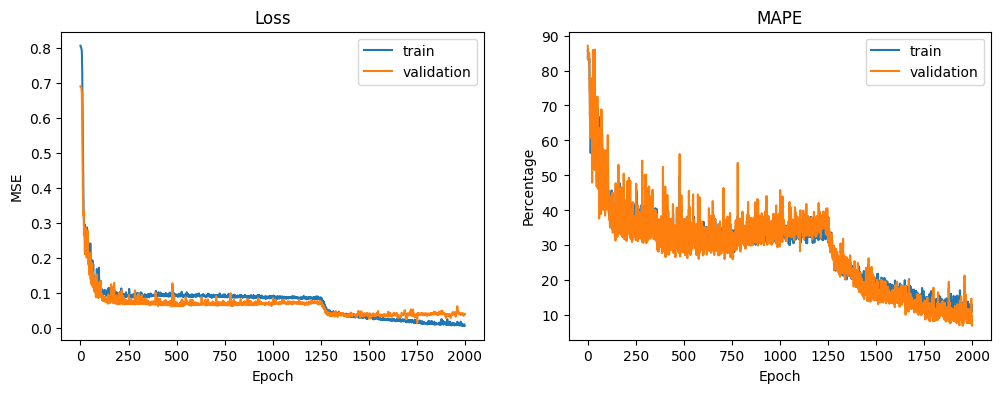

In [ ]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LSTM_input (InputLayer)     [(None, 28, 4)]              0         []                            
                                                                                                  
 CNN_input (InputLayer)      [(None, 28, 4)]              0         []                            
                                                                                                  
 layer_normalization_10 (La  (None, 28, 4)                8         ['LSTM_input[0][0]']          
 yerNormalization)                                                                                
                                                                                                  
 position_embedding_4 (Posi  (None, 28, 4)                112       ['CNN_input[0][0]'] 

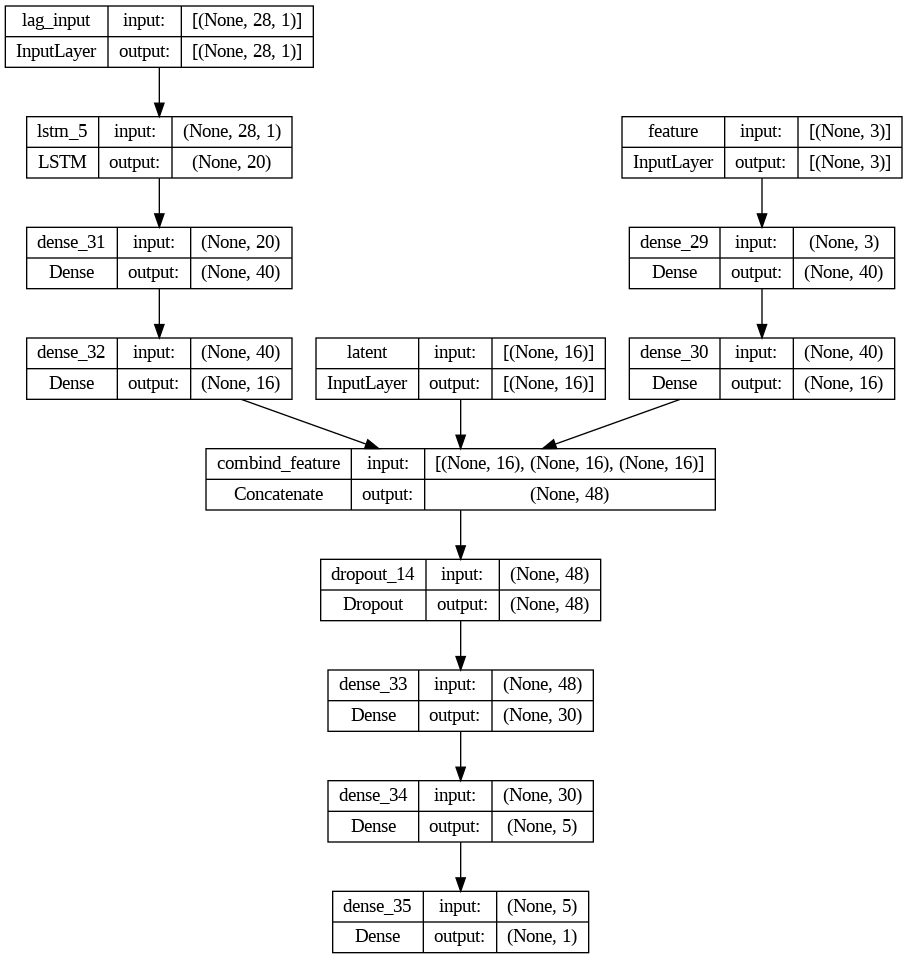

In [ ]:
# plot and save your model
import tensorflow as tf
model_transform.summary()
img_file = 'model_transform.png'
tf.keras.utils.plot_model(model_transform, to_file=img_file, show_shapes=True, show_layer_names=True)
img_file = 'model_decode.png'
tf.keras.utils.plot_model(model_decoding, to_file=img_file, show_shapes=True, show_layer_names=True)

In [ ]:
#validation
x_predictn=np.zeros((1,28))
#x_predictn[0,:]=[10,18,18,20,25,18,20,18,5,2,10,9,10,5,8,6,6,4,7,12,23,24,25,25,54,27,23]
x_predictn[0,:]=data[15,1:29]
X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=100 #blow
x_feature[0,1]=2 #fine
x_feature[0,2]=3 #thickness
X_feature = sc_f.transform(x_feature)

x_cal=np.zeros((1,time_step,4))
x_cal[:,:,0]=X_predict
x_cal[:,:,1]=X_feature[0,0]
x_cal[:,:,2]=X_feature[0,1]
x_cal[:,:,3]=X_feature[0,2]
#y=model_transform.predict([X_feature,x_cal,x_cal])
#y=sc_y.inverse_transform(y)
print(y)
#plot
#set initial
y_d=np.array([0])
y_dp=np.pad(y_d,(0,27-1),mode='constant')
ydp=np.reshape(ydp,(1,1,1))
y_predict=np.array([])
for step in range(1,28):

  y=model_transform.predict([X_feature,x_cal, x_cal,ydp])
  y_predict=np.append(y_predict,y,axis=1)
  y_predict_pad=np.pad(y_predict,(0,27-y_predict.shape[0]),mode='constant')
  ydp=np.reshape(y_predict,(1,y_predict_pad.shape[0],1))

y=sc_y.inverse_transform(y_predict)



1/1 [==============================] - 0s 31ms/step
[[12.665335  20.222157  17.452772  17.656559   8.589509  16.672186
  13.6676    17.749722  10.339917   6.512298   2.4884915  9.596858
  10.590686   9.950588   5.000565   0.8689195  2.5275192  2.0243032
   1.7829946  3.0317461  5.111828   4.523933   2.301327   2.3277225
   3.2947867  3.813728   3.302409   4.1380854]]


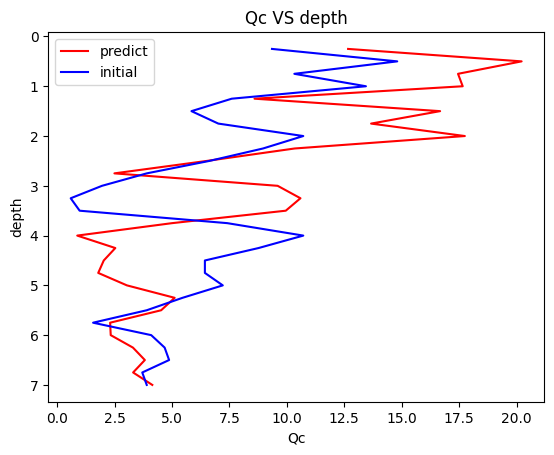

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()

In [ ]:
model_transform.save('transformer.h5')

In [ ]:
#Model generation part
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import Adam
import keras_nlp
model_transform = models.load_model('/content/drive/MyDrive/RIC/train_model/model1/transformer_medium_final.h5')
def mape(y_true, y_pred):
  mape=np.mean(np.abs((y_true - y_pred)/y_true ))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(y_true - y_pred))
  # return mean of percentage errors
  return mae

y=model_transform.predict([x_f,x_train_encoder, x_train_encoder,y_decode])

#_pred=sc_y.inverse_transform(y)

mape=mape(y_train,y)
mae=mae(y_train,y)

print('MAPE=', mape)
print('MAE=', mae)


30/30 [==============================] - 5s 44ms/step
MAPE= 7.1796924685346415
MAE= 0.03377492039120414


In [ ]:
x_f=encoder_f(x_feature,28)
x_train_encoder=encoder_x(X_train_CNN)
y_decode=padding_full(x_pad=y_train, shift=1)
y_decode = np.delete (y_decode, -1, axis=1)
y_train=out_put(y_train)

In [ ]:
import matplotlib.pyplot as plt


Y=data[:,34:62]

y_train=sc_y.inverse_transform(y_train)
# Plot the data points as a scatter plot
plt.scatter(y, y_train, s=1)

# Add labels and title
plt.xlabel('cone resistance (MPa)')
plt.ylabel('predicted cone resistance (MPa)')


# Show the plot on the screen
plt.show()

ValueError: ignored

In [ ]:
com=np.concatenate((y_pred,Y),axis=0)
np.savetxt('predict.csv', com, delimiter=',')

In [ ]:
Y_sp=y_pred.T
Y_ST=Y.T
for i in range(0,27):
  Y_p=Y_P

In [ ]:
Y_ST.shape

(28, 26)

In [ ]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df2 = pd.read_excel('/content/drive/MyDrive/RIC/RIC7aug.xlsx')
data=np.array(df2)
X=data[-2:,1:29]
Y=data[-2:,34:62]
X_feature=data[-2:,29:32]

In [ ]:
Y.shape

(2, 28)

In [ ]:
Y#scale data
X_train=X
Y_train=Y


x_train = sc.transform(X_train)
y_train=sc_y.transform(Y_train)
x_feature=sc_f.transform(X_feature)

In [ ]:
x_feature

array([[-1.37685678, -2.34417712,  0.27530479],
       [-1.37685678, -2.34417712,  0.27530479]])

In [ ]:
X_train_CNN=np.zeros((X.shape[0],X.shape[1],x_feature.shape[1]+1))
X_train_CNN[:,:,0]=x_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=x_feature[i,0]
  X_train_CNN[i,:,2]=x_feature[i,1]
  X_train_CNN[i,:,3]=x_feature[i,2]

In [ ]:
X_train_CNN

array([[[-0.93350493, -1.37685678, -2.34417712,  0.27530479],
        [-0.57271124, -1.37685678, -2.34417712,  0.27530479],
        [ 0.40178498, -1.37685678, -2.34417712,  0.27530479],
        [ 0.86765545, -1.37685678, -2.34417712,  0.27530479],
        [ 0.70489386, -1.37685678, -2.34417712,  0.27530479],
        [ 0.20522221, -1.37685678, -2.34417712,  0.27530479],
        [ 1.02954651, -1.37685678, -2.34417712,  0.27530479],
        [ 2.9617748 , -1.37685678, -2.34417712,  0.27530479],
        [ 1.8313836 , -1.37685678, -2.34417712,  0.27530479],
        [ 1.26810271, -1.37685678, -2.34417712,  0.27530479],
        [ 1.1669807 , -1.37685678, -2.34417712,  0.27530479],
        [ 3.94904658, -1.37685678, -2.34417712,  0.27530479],
        [ 3.77389936, -1.37685678, -2.34417712,  0.27530479],
        [ 0.87160822, -1.37685678, -2.34417712,  0.27530479],
        [-0.36501563, -1.37685678, -2.34417712,  0.27530479],
        [-0.57764094, -1.37685678, -2.34417712,  0.27530479],
        

In [ ]:
y=model_transform.predict([x_feature,X_train_CNN,X_train_CNN])
y_pred=sc_y.inverse_transform(y)

1/1 [==============================] - 0s 32ms/step


In [ ]:
np.savetxt('array2.csv', y_pred, delimiter=',')

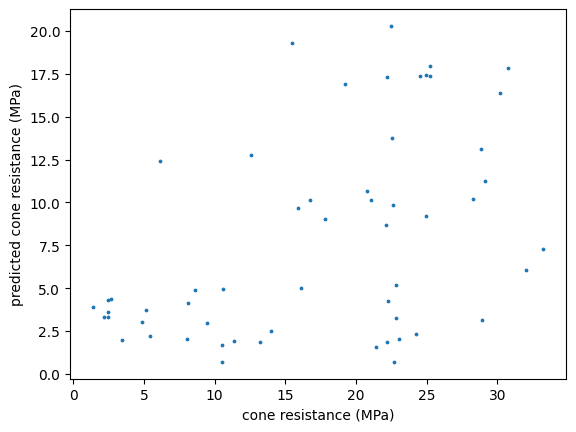

In [ ]:
import matplotlib.pyplot as plt


Y=data[-2:,34:62]

# Plot the data points as a scatter plot
plt.scatter(Y, y_pred, s=3)

# Add labels and title
plt.xlabel('cone resistance (MPa)')
plt.ylabel('predicted cone resistance (MPa)')


# Show the plot on the screen
plt.show()

In [ ]:
import pickle
pickle.dump(sc, open('scaler_x.pkl', 'wb'))
pickle.dump(sc_y, open('scaler_y.pkl', 'wb'))
pickle.dump(sc_f, open('scaler_f.pkl', 'wb'))